# Building an ePSF
Using https://photutils.readthedocs.io/en/stable/epsf.html

In [290]:
from astropy.io import fits
import numpy as np
from MTLib import PATH

with fits.open(PATH.DATAMAPS.value + 'HST/source13/source13_F160w.fits') as hdul:
    hdu = hdul[0]
    data: np.ndarray = hdu.data

### Visualize the data

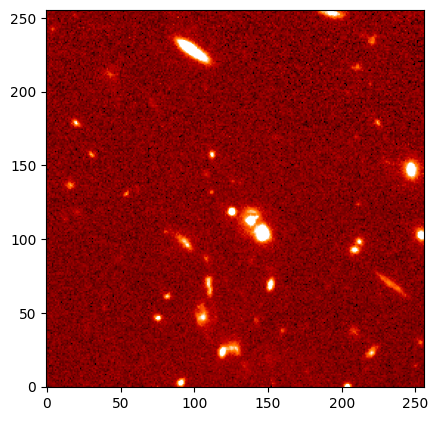

In [291]:
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5),dpi=100)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='gist_heat')

### Find peaks in the data-map

In [292]:
from photutils.detection import find_peaks
sigma = 7
peaks_tbl = find_peaks(data, threshold=0.0092488*sigma)  
print(type(peaks_tbl))
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)  

<class 'astropy.table.table.Table'>
x_peak y_peak  peak_value
------ ------ -----------
   204      0  0.40411592
    91      2  0.43537554
   220     23  0.16023454
   119     24  0.28425762
   125     26  0.14108628
   128     26  0.15764105
   253     30 0.068097055
    76     46  0.27772132
   106     47  0.20634148
   103     54 0.067105621
   ...    ...         ...
   224    179  0.11819142
   210    216 0.076933332
   105    222  0.24233444
    98    229  0.79402161
   220    233 0.090107456
   221    236 0.076224066
    89    250 0.066683374
   200    251 0.088485569
   195    252  0.22755279
   198    252  0.14853247
   192    253  0.34758234
Length = 49 rows


### Extract cutouts around the peaks
We plan to extract 10 x 10 pixel cutouts of our selected stars, so let’s explicitly exclude stars that are too close to the image boundaries (because they cannot be extracted):

In [293]:
size = 20
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))

Let us also exclude peaks where the seperation is shorter than the cutout size

In [294]:
factor = 0.5

N = len(mask)
tmp_mask = mask.copy()
# Go through all the peaks
for i in range(N):
    # if the peak is not within the mask go on to next peak
    if not tmp_mask[i]:
        continue
    # Go through the remaining peaks
    for j in range(i+1,N):
        # if the peak is not within the mask, go on to the next peak
        if not tmp_mask[j]:
            continue
        dist = np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2)
        if dist < size*factor:
            print(f'{i}({x[i]},{y[i]}) is too close to {j}({x[j]},{y[j]}) | {dist:.3f}')
            mask[i], mask[j] = False, False
    


3(119,24) is too close to 4(125,26) | 6.325
3(119,24) is too close to 5(128,26) | 9.220
4(125,26) is too close to 5(128,26) | 3.000
8(106,47) is too close to 9(103,54) | 7.616
11(111,65) is too close to 13(109,69) | 4.472
12(238,67) is too close to 15(232,69) | 6.325
15(232,69) is too close to 16(228,73) | 5.657
18(209,93) is too close to 21(212,98) | 5.831
19(95,96) is too close to 20(93,98) | 2.828
19(95,96) is too close to 22(90,101) | 7.071
20(93,98) is too close to 22(90,101) | 4.243
25(137,112) is too close to 26(139,113) | 2.236
25(137,112) is too close to 27(142,115) | 5.831
25(137,112) is too close to 29(140,118) | 6.708
25(137,112) is too close to 30(138,119) | 7.071
26(139,113) is too close to 27(142,115) | 3.606
26(139,113) is too close to 29(140,118) | 5.099
26(139,113) is too close to 30(138,119) | 6.083
27(142,115) is too close to 29(140,118) | 3.606
27(142,115) is too close to 30(138,119) | 5.657
29(140,118) is too close to 30(138,119) | 2.236
40(105,222) is too close t

Let's quickly visualize the areas

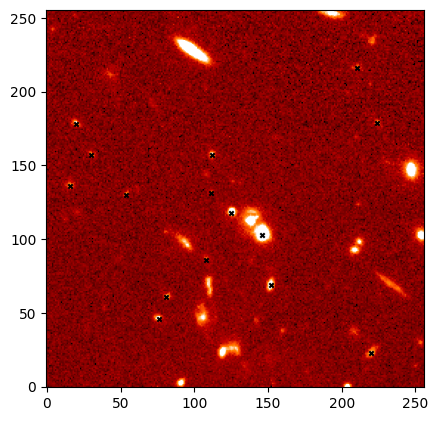

Number of selected stars: 15


In [295]:
plt.figure(figsize=(5,5),dpi=100)
norm = simple_norm(data, 'sqrt', percent=99.)
plt.imshow(data, norm=norm, origin='lower', cmap='gist_heat')

for xp, yp in zip(x[mask],y[mask]):
    plt.scatter(xp,yp,s=10,c='k',marker='x')

plt.show()

print(f'Number of selected stars: {sum(mask)}')

Now let’s create the table of good star positions:

In [296]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask]  

The extract_stars() method requires the input data as an NDData object. An NDData object is easy to create from our data array:

In [297]:
from astropy.nddata import NDData
nddata = NDData(data=data) 

Let’s extract the 10 x 10 pixel cutouts of our selected stars:

In [298]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=size)  

The function returns a EPSFStars object containing the cutouts of our selected stars. Lets see some of them

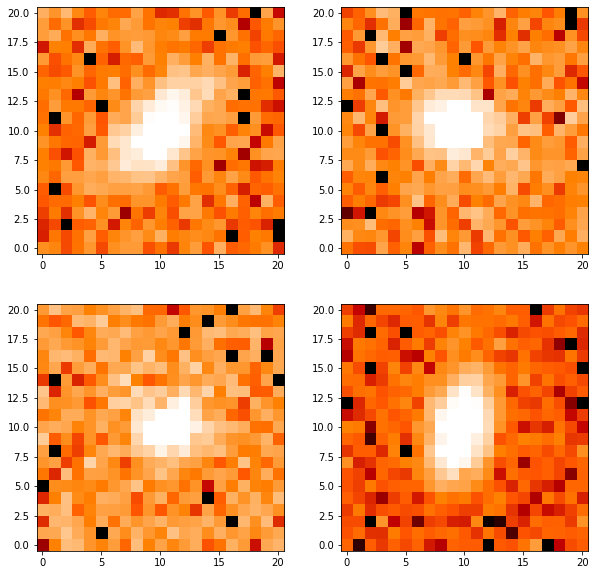

In [299]:

nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=95.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='gist_heat')

### Build the ePSF

In [300]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=6, maxiters=15, progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  

### The constructed ePSF

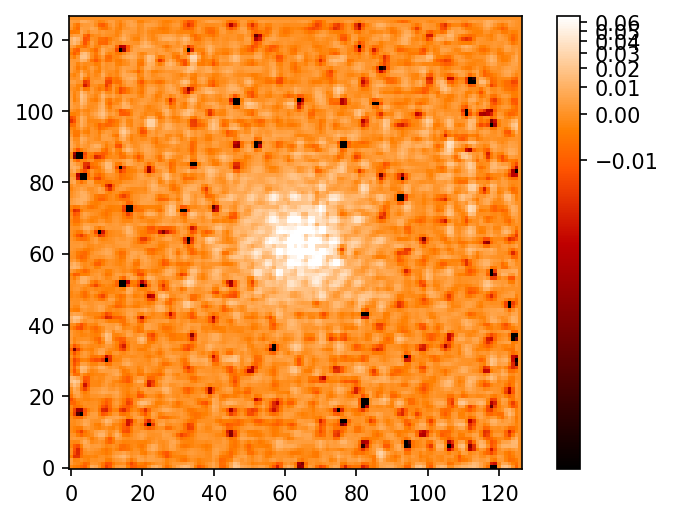

In [301]:
norm = simple_norm(epsf.data, 'log', percent=99.)
plt.figure(dpi=150)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='gist_heat')
plt.colorbar()

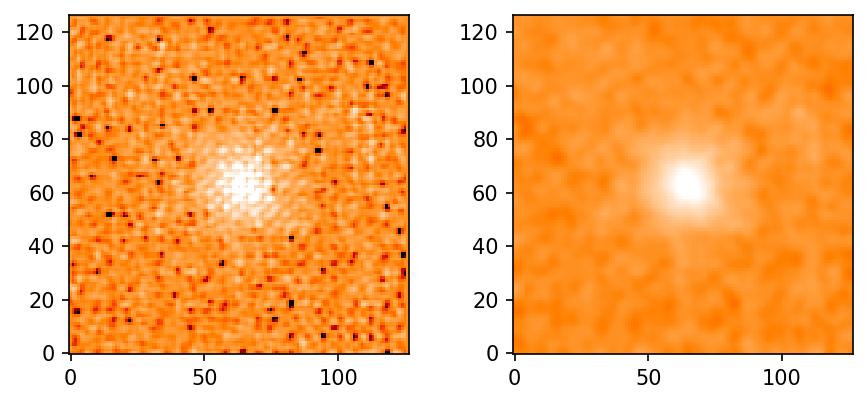

In [302]:
import scipy.ndimage as ndimage

fig, axs = plt.subplots(1, 2, figsize=(7, 3),dpi=150)
axs = axs.flatten()

axs[0].imshow(epsf.data, norm=norm, origin='lower', cmap='gist_heat',interpolation='nearest')
# Note the 0 sigma for the last axis, we don't wan't to blurr the color planes together!
img = ndimage.gaussian_filter(epsf.data, sigma=(2, 2), order=0)
axs[1].imshow(img, interpolation='nearest', norm=norm, origin='lower', cmap='gist_heat')
plt.show()